In [1]:
import os
import math
import torch
import wandb
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.model_summary import ModelSummary
from torchvision import transforms

import matplotlib.pyplot as plt

from data.datamodule import Animal_DataModule
from data.datamodule import MultiClassImageDataModule

/opt/anaconda3/envs/VDKI-Projekt/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Loading Configuration

In the following steps, we will load the configuration settings using the `load_configuration` function. The configuration is stored in the `config` variable which will be used throughout the script.

In [11]:
from config.load_configuration import load_configuration
config = load_configuration()

PC Name: MacBook-Pro-de-Marie-7.local
Loaded configuration from config/config_marie.yaml


### Setting Seeds for Reproducibility

To ensure comparable and reproducible results, we set the random seed using the `seed_everything` function from PyTorch Lightning. This helps in achieving consistent behavior across multiple runs of the notebook.

In [ ]:
pl.seed_everything(config['seed'])
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"   # disable oneDNN optimizations for reproducibility

Seed set to 42


42

### Checking for GPU Devices

In this step, we check for the availability of GPU devices and print the device currently being used by PyTorch. This ensures that the computations are performed on the most efficient hardware available.

In [5]:
# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Torch Version: ', torch.__version__)
print('Using device: ', device)
if device.type == 'cuda':
    print('Cuda Version: ', torch.version.cuda)
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    torch.set_float32_matmul_precision('high')

Torch Version:  2.7.0+cpu
Using device:  cpu


### Defining Transformations and Instantiating DataModule

In this step, we will define the necessary data transformations and initialize the `Animal_DataModule` with the provided configuration.

Processing file: hase_0324_nok_v4
Processing file: katze_0030_nok_v2
Processing file: hase_0100_nok_v5
Processing file: kaninchen_0336_ok_v4
Processing file: kaninchen_1079_ok_v5
Processing file: kaninchen_0816_ok_v5
Processing file: kaninchen_0895_ok_v0
Processing file: maus_0052_nok_v4
Processing file: kaninchen_0422_ok_v4
Processing file: katze_0082_nok_v1
Processing file: hase_0425_nok_v1
Processing file: katze_0039_nok_v3
Processing file: waschbaer_0014_nok_v2
Processing file: waschbaer_0099_nok_v3
Processing file: schlange_0112_nok_v5
Processing file: eichhoernchen_0161_nok_v0
Processing file: hamster_0062_nok_v0
Processing file: kaninchen_0869_ok_v5
Processing file: ratte_0044_nok_v5
Processing file: kaninchen_0294_ok_v4
Processing file: hund_0141_nok_v1
Processing file: hund_0076_nok_v4
Processing file: hund_0124_nok_v4
Processing file: hase_0043_nok_v5
Processing file: eichhoernchen_0124_nok_v1
Processing file: frettchen_0049_nok_v5
Processing file: kaninchen_0001_ok_v0
Proces

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


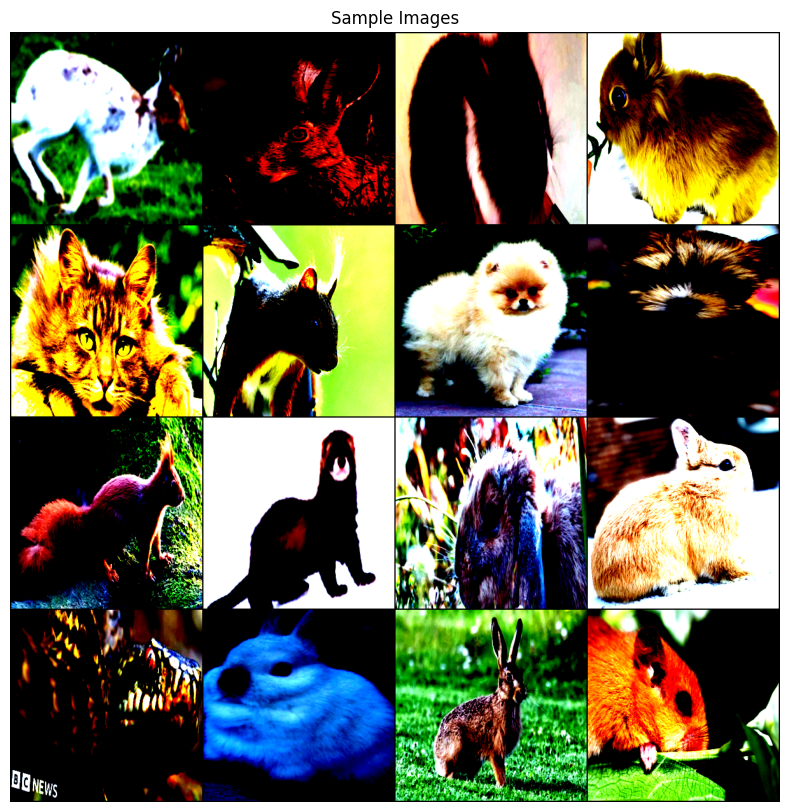

lables:
tensor([ 7,  7,  1,  1,  6,  4,  8,  8,  4,  5,  1,  1, 14,  1,  7, 12])
Train dataset size: 13493
Validation dataset size: 2918
Test dataset size: 2908


In [ ]:
# TODO: Define transformations here

# Example for transformation
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize images to match EfficientNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])


dm = MultiClassImageDataModule(data_dir=config['path_to_split_aug_pics'], name_list=config['name_list'], transform=transform, batch_size=config['batch_size'], num_workers=2, persistent_workers=True)
dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

# Show a few images from the training set
from torchvision.utils import make_grid
def show_images(loader):
    images, labels = next(iter(loader))
    images = images[:16]  # Show only the first 16 images
    labels = labels[:16]
    grid = make_grid(images, nrow=4, padding=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.title('Sample Images')
    plt.axis('off')
    plt.show()
    print(labels[:16])  # Print corresponding labels
show_images(train_loader)

print('Train dataset size:', len(dm.train_dataset))
print('Validation dataset size:', len(dm.val_dataset))
print('Test dataset size:', len(dm.test_dataset))

### Creating the Model

In this step, we will define the model architecture and print its summary using the `ModelSummary` utility from PyTorch Lightning. This provides an overview of the model's layers, parameters, and structure.

In [ ]:
# model = ...
# print(ModelSummary(model, max_depth=-1))  

In [ ]:
# Initialize the Wandb logger
wandb_config = {
    'project_name': config['wandb_project_name'],
    'experiment_name': config['wandb_experiment_name'],
    'batch_size': config['batch_size'],
    'max_epochs': config['max_epochs'],
    'learning_rate': config['learning_rate'],
}

wandb_logger = WandbLogger(
    project=config['wandb_project_name'],
    name=config['wandb_experiment_name'],
    config=config
    # save_dir=os.path.join(config['path_to_data'], 'logs')
)

In [ ]:
# Initialize Trainer with wandb logger, using early stopping callback (https://lightning.ai/docs/pytorch/stable/common/early_stopping.html)
trainer = Trainer(
    max_epochs=config['max_epochs'], 
    default_root_dir='model/checkpoint/', #data_directory, 
    accelerator="auto", 
    devices="auto", 
    strategy="auto",
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')], 
    logger=wandb_logger)

# Training of the model
trainer.fit(model=model, datamodule=dm)

# Finish wandb
wandb.finish()